<a href="https://colab.research.google.com/github/nidanafila/Image-Classification-Model-Deployment/blob/main/Image_Classification_Model_Deployment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Nama : Nida Nafila

E-mail : naifanida5858@gmail.com

In [1]:
#install data dari kaggle
!pip install -q kaggle
from google.colab import files
files.upload()

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!ls ~/.kaggle

#download dataset
!kaggle datasets download -d tongpython/cat-and-dog

!mkdir cat-and-dog
!unzip cat-and-dog.zip
!ls cat-and-dog

Streaming output truncated to the last 5000 lines.
  inflating: training_set/training_set/cats/cat.3704.jpg  
  inflating: training_set/training_set/cats/cat.3705.jpg  
  inflating: training_set/training_set/cats/cat.3706.jpg  
  inflating: training_set/training_set/cats/cat.3707.jpg  
  inflating: training_set/training_set/cats/cat.3708.jpg  
  inflating: training_set/training_set/cats/cat.3709.jpg  
  inflating: training_set/training_set/cats/cat.371.jpg  
  inflating: training_set/training_set/cats/cat.3710.jpg  
  inflating: training_set/training_set/cats/cat.3711.jpg  
  inflating: training_set/training_set/cats/cat.3712.jpg  
  inflating: training_set/training_set/cats/cat.3713.jpg  
  inflating: training_set/training_set/cats/cat.3714.jpg  
  inflating: training_set/training_set/cats/cat.3715.jpg  
  inflating: training_set/training_set/cats/cat.3716.jpg  
  inflating: training_set/training_set/cats/cat.3717.jpg  
  inflating: training_set/training_set/cats/cat.3718.jpg  
  infl

In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import cv2
import sklearn
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Flatten, BatchNormalization, Dropout, Input
from tensorflow.keras.layers import Rescaling
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom
from keras import callbacks
from keras.layers import Dense, Flatten, BatchNormalization, GlobalAveragePooling2D, Dropout, Input
from keras import Model
from keras.layers import  Conv2D, MaxPool2D, add
from keras.preprocessing import image
import random
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'

In [3]:
training_path = '../content/training_set/training_set/'
test_path = '../content/test_set/test_set'
IMAGE_SIZE = (100, 150)
BATCH_SIZE = 32

In [4]:
train_ds = keras.utils.image_dataset_from_directory(
    directory="../content/training_set/training_set",
    batch_size=BATCH_SIZE,
    image_size=IMAGE_SIZE,
    shuffle=True,
    seed=42,
    validation_split=0.2,
    subset='training'
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    directory="../content/test_set/test_set",
    batch_size=BATCH_SIZE,
    image_size=IMAGE_SIZE,
    shuffle=True,
    seed=42
)

valid_ds = tf.keras.utils.image_dataset_from_directory(
    directory="../content/training_set/training_set",
    batch_size=BATCH_SIZE,
    image_size=IMAGE_SIZE,
    shuffle=True,
    seed=42,
    validation_split=0.2,
    subset='validation'
)

Found 8005 files belonging to 2 classes.
Using 6404 files for training.
Found 2023 files belonging to 2 classes.
Found 8005 files belonging to 2 classes.
Using 1601 files for validation.


In [5]:
cnt_imgs = 16
cat_path = training_path + '/cats'
dog_path = training_path + '/dogs'
cat_imgs = os.listdir(cat_path)[:cnt_imgs]
dog_imgs = os.listdir(dog_path)[:cnt_imgs]

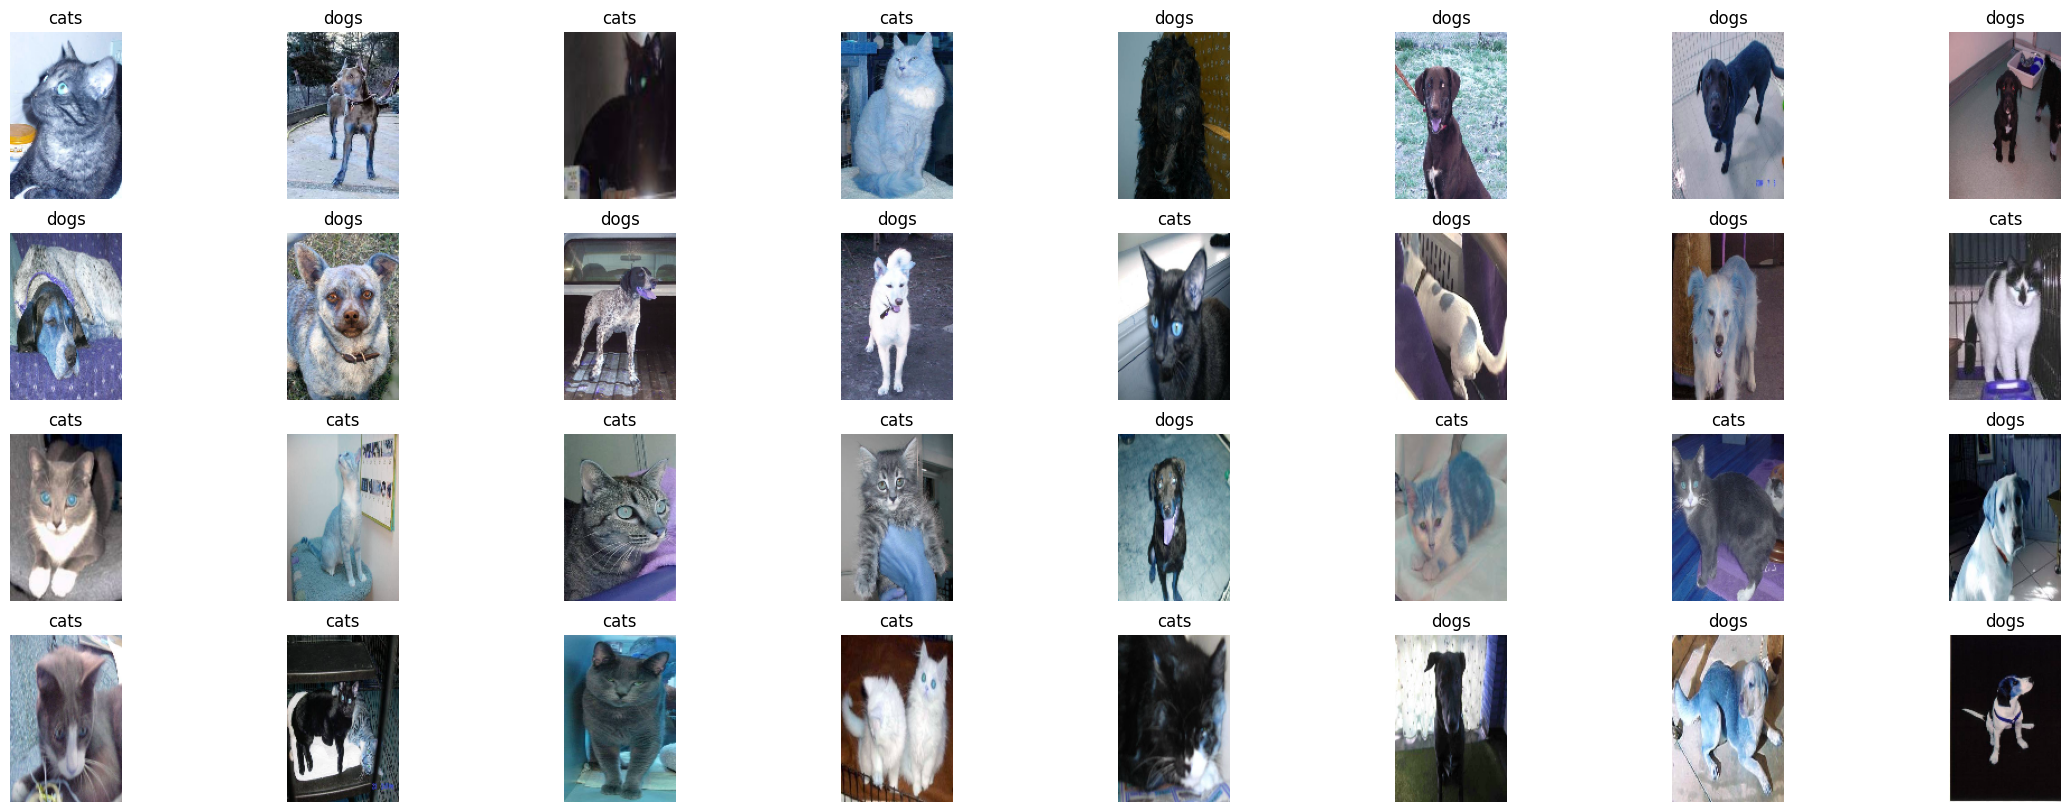

In [6]:
counter = 0
cat_imgs_path = [cat_path + '/' + i for i in cat_imgs]
dog_imgs_path = [dog_path + '/' + j for j in dog_imgs]
all_imgs = cat_imgs_path + dog_imgs_path
random.shuffle(all_imgs)

plt.figure(figsize=(28, 10))
for img_path in all_imgs:
    plt.subplot(4, 8, counter + 1)
    img = cv2.imread(img_path)
    img = cv2.resize(img, IMAGE_SIZE)
    label = img_path[len(training_path) + 1: img_path.rfind('/')]
    plt.imshow(img)
    plt.title(label)
    plt.axis('off')
    counter += 1

In [7]:
def check_cnt_label(label: str) -> int:
    cnt_object = 0
    paths = [training_path, test_path]
    for path in paths:
        path += '/' + label
        cnt_object += len(os.listdir(path))
    return cnt_object

CNT_CAT = check_cnt_label('cats')
CNT_DOG = check_cnt_label('dogs')

In [8]:
fig = go.Figure()
fig.add_trace(go.Bar(
    x=['Cats', 'Dogs'],
    y=[CNT_CAT, CNT_DOG],
    width=[0.4, 0.4]))

fig.update_layout(title='Classes and their number in the dataset', title_x=0.5)

In [9]:
rescale = Rescaling(scale=1.0 / 255)

train_ds = train_ds.map(lambda image, label: (rescale(image), label))

valid_ds  = valid_ds.map(lambda image, label: (rescale(image), label))

test_ds = test_ds.map(lambda image, label: (rescale(image), label))

In [10]:
EPOCHS = 35
CALLBACKS = [
    callbacks.EarlyStopping(monitor='loss', min_delta=0.01, patience=7, verbose=1),
    callbacks.ReduceLROnPlateau(monitor='loss', factor=0.1, min_delta=0.01, min_lr=1e-10, patience=2, verbose=1, mode='auto')]

In [11]:
inputs = Input(shape=(IMAGE_SIZE + (3,)))

x = Conv2D(32, (3, 3), activation='elu')(inputs)
x = BatchNormalization()(x)
x = Conv2D(64, (3, 3), activation='elu')(x)
block_1_output = MaxPool2D(pool_size=(3, 3))(x)

x = Conv2D(64, (3, 3), activation='elu', padding='same')(block_1_output)
x = BatchNormalization()(x)
x = Conv2D(64, (3, 3), activation='elu', padding='same')(x)
block_2_output = add([x, block_1_output])

x = Conv2D(64, (3, 3), activation='elu', padding='same')(block_2_output)
x = BatchNormalization()(x)
x = Conv2D(64, (3, 3), activation='elu', padding='same')(x)
block_3_output = add([x, block_2_output])

x = Conv2D(128, (3, 3), activation='elu')(block_3_output)
x = MaxPool2D(pool_size=(2, 2))(x)
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='elu')(x)
output = Dense(1, activation='sigmoid')(x)

In [12]:
model = Model(inputs, output)
model.compile(metrics=['Accuracy'], loss='binary_crossentropy', optimizer='Adam')
history = model.fit(train_ds, epochs=EPOCHS, validation_data=valid_ds, callbacks=CALLBACKS)

Epoch 1/35
201/201 [==============================] - 26s 73ms/step - loss: 0.6867 - Accuracy: 0.5803 - val_loss: 0.7504 - val_Accuracy: 0.4959 - lr: 0.0010
Epoch 2/35
201/201 [==============================] - 17s 83ms/step - loss: 0.6573 - Accuracy: 0.6007 - val_loss: 0.6965 - val_Accuracy: 0.5734 - lr: 0.0010
Epoch 3/35
201/201 [==============================] - 13s 62ms/step - loss: 0.6208 - Accuracy: 0.6544 - val_loss: 0.6269 - val_Accuracy: 0.6515 - lr: 0.0010
Epoch 4/35
201/201 [==============================] - 15s 74ms/step - loss: 0.5763 - Accuracy: 0.7014 - val_loss: 0.5657 - val_Accuracy: 0.7133 - lr: 0.0010
Epoch 5/35
201/201 [==============================] - 13s 64ms/step - loss: 0.5311 - Accuracy: 0.7306 - val_loss: 0.6693 - val_Accuracy: 0.6540 - lr: 0.0010
Epoch 6/35
201/201 [==============================] - 16s 78ms/step - loss: 0.5169 - Accuracy: 0.7411 - val_loss: 0.5874 - val_Accuracy: 0.7027 - lr: 0.0010
Epoch 7/35
201/201 [==============================] - 19s 

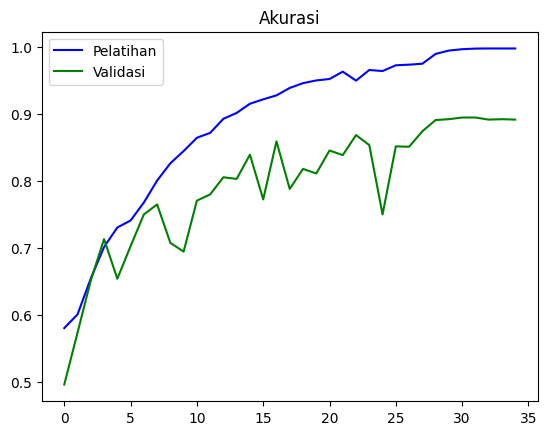

<Figure size 640x480 with 0 Axes>

In [13]:
import matplotlib.pyplot as plt

accuracy = history.history['Accuracy']
validation_accuracy = history.history['val_Accuracy']

epochs = range(len(accuracy))

plt.plot(epochs, accuracy, 'b', label='Pelatihan')
plt.plot(epochs, validation_accuracy, 'g', label='Validasi')
plt.title('Akurasi')
plt.legend(loc=0)
plt.figure()
plt.show()

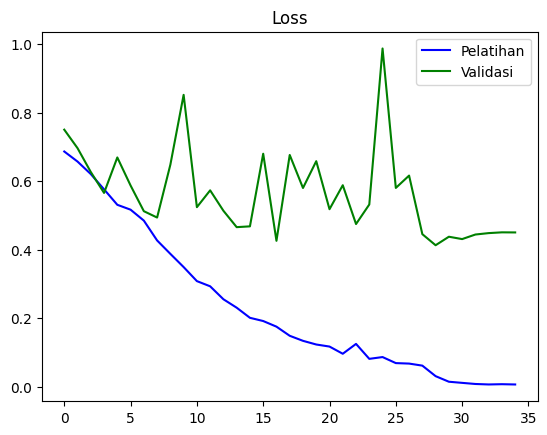

<Figure size 640x480 with 0 Axes>

In [14]:
loss = history.history['loss']
validation_loss = history.history['val_loss']

epochs = range(len(loss))

plt.plot(epochs, loss, 'b', label='Pelatihan')
plt.plot(epochs, validation_loss, 'g', label='Validasi')
plt.title('Loss')
plt.legend(loc=0)
plt.figure()

plt.show()

In [15]:
!pip install tensorflowjs

!tensorflowjs_converter --input_format=keras model.h5 tfjs_model

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.2/89.2 kB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.3/15.3 MB 65.0 MB/s eta 0:00:00
2024-01-29 16:00:35.486690: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-29 16:00:35.486750: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-29 16:00:35.488081: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-29 16:00:36.588502: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Traceback (most recent call last):
  File "/usr/local/bin/tensorflowjs_converter

In [16]:
import pathlib
export_dir = '/content/'
tf.saved_model.save(model, export_dir)
converter = tf.lite.TFLiteConverter.from_saved_model(export_dir)

converter.optimizations = [tf.lite.Optimize.DEFAULT]

tflite_model = converter.convert()

tflite_model_file = pathlib.Path('./model.tflite')
tflite_model_file.write_bytes(tflite_model)

tf.saved_model.save(model, '/content/')